## SET UP

In [16]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import pandas as pd
import sklearn as skl 
import numpy as np
import os

In [17]:

# load data 
train_csv = pd.read_csv("./train.csv")

In [18]:
train_csv.head(2)

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False


In [19]:
# count files 


# count = 0
# for _, _, files_list in os.walk('./train_thumbnails/'):
#     count += len(files_list)
# print('file count:', count)


In [20]:
source = './train_thumbnails/'
files_list = os.listdir(source)
labels = train_csv["label"].unique().tolist()
labels_list = train_csv["label"].tolist()

In [21]:
# split images into subfolders TO BE RUN ONCE 
# import shutil
# i=0
# for file in files_list :
#      if (file not in labels ):
#         shutil.move(
#             source + file,
#             f'{source}{labels_list[i]}/'
#             )
#         i += 1

In [22]:
# create data sets
# train_dir = 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/'

BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=513,
                                                            image_size=IMG_SIZE,
                                                            # subset ="training",
                                                            # validation_split = 0.2,
                                                            seed = 123)

Found 513 files belonging to 5 classes.


## Data visualization

In [23]:
# import matplotlib.pyplot as plt 
# class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(4):
#     # print(class_names[labels[i]])
#     ax = plt.subplot(2, 2, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [24]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

## Transfert learning 

### Features extraction 

InceptionResnetV2  
MobileNetV3   
MobileNetV3Small   
Xception  49%
ResNet50 
DenseNet121


In [52]:
# # create the base pre-trained model
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    # input_shape=(224, 224, 3),
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

51877672/51877672 [==============================] - 6s 0us/step


In [53]:
base_model.trainable = False

In [54]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [55]:
train_batches = train_dataset.cardinality().numpy()
# val_batches = validation_dataset.cardinality().numpy()

print(f"num batches : {train_batches}")

num batches : 1


In [56]:
# reshape train data
train_image,labels_train= next(iter(train_dataset))
batch0 = preprocess_input(train_image)
batch0= base_model(batch0,training = False)
shape = batch0.shape
features_reshaped_train = np.reshape(batch0,(-1,shape[1]*shape[2]*shape[3]))

In [ ]:
# class_names = train_dataset.class_names
# class_names

In [57]:
# create class weights

weights = skl.utils.class_weight.compute_class_weight('balanced',
                                                      classes = [i for i in range(5)],
                                                    #    y=[class_names[id] for id in labels_train.numpy()] )
                                                       y=labels_train.numpy()
                                                    )
class_weights = {i: round(weights[i],2) for i in range(5) }
class_weights


{0: 1.1, 1: 0.86, 2: 0.49, 3: 2.23, 4: 2.33}

In [58]:
# create models dict
Models = dict()
Scores = dict()


In [59]:
# fit and score function 
def fit_and_score(model,X_train,y_train,X_test,y_test):
    fit = model.fit(X_train,y_train)
    score = fit.score(X_test,y_test)
    return(score)

In [60]:

# split data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# y = [class_names[id] for id in labels_train.numpy()]  

X_train, X_test, y_train, y_test = train_test_split(features_reshaped_train,
                                                    labels_train.numpy(),
                                                    # y,
                                                    test_size=0.2, 
                                                    random_state=2020)

In [61]:
#imports 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree

In [72]:
# Models dict
# glm
Models["glm"] = LogisticRegression(max_iter = 1000,class_weight=class_weights,
                                   random_state=2020)
# logr reg CV
Models["logRegCV"] = LogisticRegressionCV(cv = 5,max_iter = 1000,
                                          class_weight=class_weights,random_state=2020)
# ridge classifier 
Models["ridgeClf"]= linear_model.RidgeClassifier(alpha=.5,max_iter = 500,
                                                 class_weight=class_weights,random_state=2020)
# ridge classifier CV
Models["ridgeCV"]= linear_model.RidgeClassifierCV(alphas = [0.1,0.2,0.3,0.4,0.5,0.6],
                                                  cv = 10,class_weight=class_weights,)

# Decision tree
Models["DT"] = tree.DecisionTreeClassifier(random_state=2020)


In [73]:
#fit and score 
for model_keys in Models:
    print(model_keys)
    model = Models[model_keys] 
    Scores[model_keys] = fit_and_score(model,X_train,y_train,X_test,y_test)

glm
logRegCV
ridgeClf


/Users/mpaga/python/envs/DL/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.95686e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


ridgeCV


/Users/mpaga/python/envs/DL/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=1.17737e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/mpaga/python/envs/DL/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=1.21988e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/mpaga/python/envs/DL/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=1.15756e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/mpaga/python/envs/DL/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=1.08644e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/m

DT


In [69]:
# scores df
scores_df = pd.DataFrame(Scores.values(),
             index = Models.keys(),
             columns = ["scores"]
             )
(scores_df.sort_values(by ="scores",ascending=False)
.head(2)
)

,scores
ridgeClf,0.300971
ridgeCV,0.300971
glm,0.291262
logRegCV,0.271845
DT,0.233010


In [ ]:

# print("pred:",fit.predict(X_test).tolist())
# print("true:",[y_test[i] for i in range(len(y_test))])

In [65]:
os.system('say "end of features extraction" ')

0

### Freezing base model and training

In [24]:
# create data sets
# train_dir = 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/'

BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset ="training",
                                                            validation_split = 0.2,
                                                            seed = 123)

Found 513 files belonging to 5 classes.
Using 411 files for training.


In [25]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 subset = "validation",
                                                                 validation_split = 0.2,
                                                            seed = 123)

Found 513 files belonging to 5 classes.
Using 102 files for validation.


In [27]:
# test dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [28]:
# Configure datasets for perf
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [29]:
#  augmentation layers
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip('horizontal'),
tf.keras.layers.RandomFlip('vertical'),
tf.keras.layers.RandomFlip('horizontal_and_vertical'),
tf.keras.layers.RandomRotation(factor=0.2),
tf.keras.layers.RandomBrightness(0.2),
#new added layers
tf.keras.layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1]),
tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
])

In [30]:
# add a global spatial average pooling layer
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)


In [31]:
# this is the model we will train
model = Model(inputs= inputs, outputs=predictions)

In [32]:
len(model.trainable_variables)

2

In [33]:
# compile model 
base_learning_rate = 1e-6
model.compile(tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
# optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics="accuracy")

# tensorboard 
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [34]:
initial_epochs =10

loss0,accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 12s 519ms/step - loss: 1.8241 - accuracy: 0.2895


In [35]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False


In [36]:
# train the model on the new data for a few epochs
history = model.fit(train_dataset,
          epochs=initial_epochs,
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)


Epoch 1/10
13/13 [==============================] - 76s 4s/step - loss: 1.6148 - accuracy: 0.3844 - val_loss: 1.6476 - val_accuracy: 0.2632
Epoch 2/10
13/13 [==============================] - 69s 4s/step - loss: 1.6158 - accuracy: 0.3771 - val_loss: 1.5909 - val_accuracy: 0.3158
Epoch 3/10
13/13 [==============================] - 68s 4s/step - loss: 1.6182 - accuracy: 0.3674 - val_loss: 1.5311 - val_accuracy: 0.3684
Epoch 4/10
13/13 [==============================] - 68s 4s/step - loss: 1.6255 - accuracy: 0.3650 - val_loss: 1.6732 - val_accuracy: 0.1842
Epoch 5/10
13/13 [==============================] - 69s 4s/step - loss: 1.6199 - accuracy: 0.3796 - val_loss: 1.6571 - val_accuracy: 0.2632
Epoch 6/10
13/13 [==============================] - 68s 4s/step - loss: 1.6265 - accuracy: 0.3552 - val_loss: 1.8113 - val_accuracy: 0.2368
Epoch 7/10
13/13 [==============================] - 68s 4s/step - loss: 1.6131 - accuracy: 0.3747 - val_loss: 1.7664 - val_accuracy: 0.2895
Epoch 8/10
13/13 [==

### learning curve 

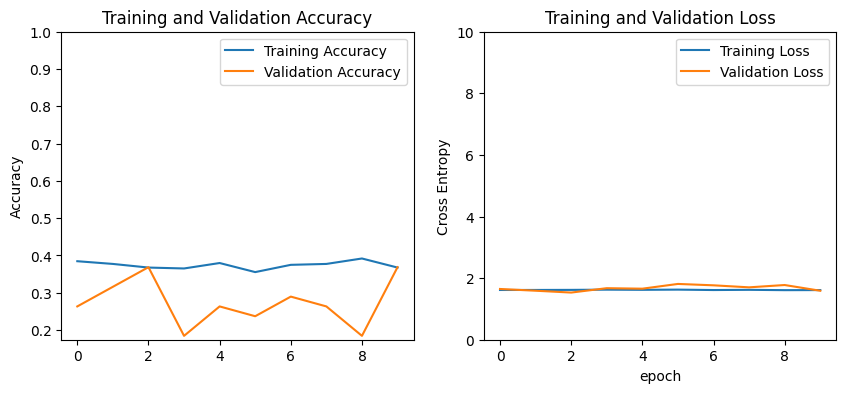

In [37]:
# plot training and validation metrics
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:

os.system('say "end tranfert learning" ')

0

### Fine-tuning 

In [39]:
# un-freeze model weights
base_model.trainable = True

In [40]:
n_layers = len(base_model.layers)
print(n_layers)


427


In [41]:
n_layers*9//10

284

In [42]:

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
n_trainable_layers = n_layers*9//10
for layer in model.layers[:n_trainable_layers]:
   layer.trainable = False
for layer in model.layers[n_trainable_layers:]:
   layer.trainable = True


#### Recompile model

In [ ]:
# from tensorflow.keras.optimizers import SGD
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = "accuracy")

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
          epochs=total_epochs,
          initial_epoch = history.epoch[-1],
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

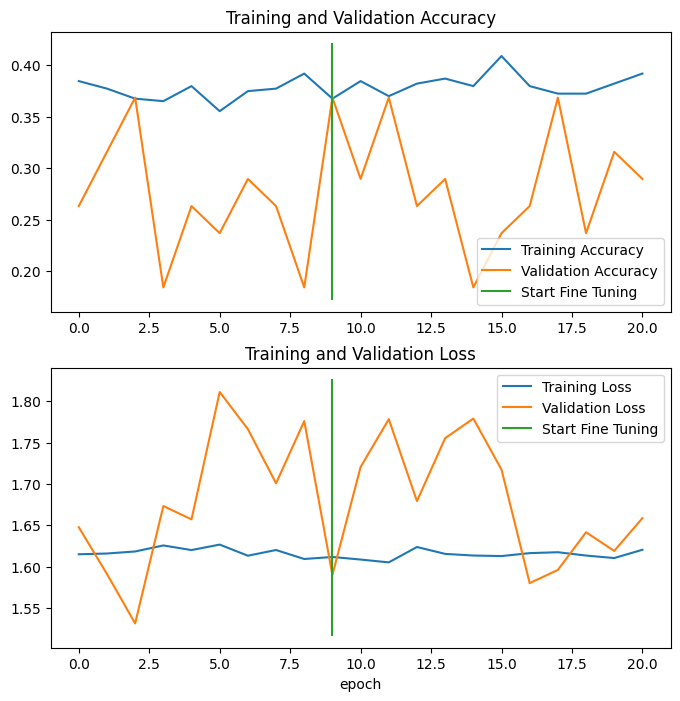

In [45]:
# plot training and validation metrics
import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

In [47]:
test_image_batch,test_label_batch = next(iter(test_dataset))

In [48]:
predicted_batch = model.predict(test_image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1,)
test_labels = [labels[id] for id in test_label_batch]
predicted_labels = [labels[id] for id in predicted_id]
print("test labels:",test_labels)
print("pred labels:",predicted_labels)

2023-11-26 07:28:08.885759: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model/sequential/random_crop/cond/branch_executed/_10


1/1 [==============================] - 7s 7s/step
test labels: ['EC', 'HGSC', 'LGSC', 'EC', 'CC', 'EC', 'EC', 'LGSC', 'EC', 'EC', 'EC', 'EC', 'EC', 'HGSC', 'MC', 'LGSC', 'EC', 'EC', 'LGSC', 'EC', 'EC', 'EC', 'LGSC', 'MC', 'HGSC', 'LGSC', 'EC', 'LGSC', 'LGSC', 'EC', 'EC', 'LGSC']
pred labels: ['MC', 'EC', 'EC', 'EC', 'MC', 'EC', 'MC', 'EC', 'EC', 'EC', 'MC', 'EC', 'LGSC', 'EC', 'EC', 'EC', 'MC', 'EC', 'MC', 'EC', 'MC', 'LGSC', 'EC', 'EC', 'EC', 'MC', 'EC', 'EC', 'EC', 'MC', 'EC', 'MC']



Not quite quite good !!!

## hyper-params tuning : TO DO 

In [49]:
os.system('say "End of fine-tuning"')

0